In [1]:
import numpy as np
import pandas as pd
import torch
from config import load_config
from pathlib import Path
from lightning.pytorch.loggers.wandb import WandbLogger
from tqdm import tqdm
from tsnecuda import TSNE
from matplotlib import pyplot as plt
import seaborn as sns
import faiss

# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')

/tmp/ipykernel_2624162/3445827236.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# parameters
dataset_name = ""
model_name = "resnet_edl_mse"
ood = ""

In [3]:
# Parameters
dataset_name = "rbc_phase"
ood = ""


In [4]:
# initialize data attributes and loaders
config = load_config(
    dataset_name = dataset_name,
    model_name = model_name,
    ood = ood,
)
config.load_data()
config.print_labels()
dm = config.datamodule

assert dm

In [5]:
# initialize data modules
dm.setup("fit")
dm.setup("test")
dm.setup("predict")

RBC Dataset V.2 => All pateints
Dataset split type train, image type: phase


Loaded 4214 images
RBC Dataset V.2 => All pateints
Dataset split type val, image type: phase


Loaded 1421 images
RBC Dataset V.2 => All pateints
Dataset split type test, image type: phase


Loaded 1421 images
RBC Dataset V.2 => All pateints
Dataset split type test, image type: phase


Loaded 0 images


In [6]:
# model ids
ood_str = ":".join(map(str, config.ood))
df = pd.read_csv("ids.csv").fillna("")
model_id = df[(df.dataset_name == dataset_name) & (df.model_name == model_name) & (df.ood == ood)].id.item()
print(ood_str, model_id)

 crx4x4ee


In [7]:
# load model and weights
model = config.get_model()
artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/robustml/model-{model_id}:best")
model = model.__class__.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb: Downloading large artifact model-crx4x4ee:best, 58.48MB. 1 files... 


wandb:   1 of 1 files downloaded.  


Done. 0:0:0.2


In [8]:
# create data loaders
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()
if ood_str:
    predict_loader = dm.predict_dataloader()

In [9]:
# forward pass
with torch.no_grad():
    trn_inp = []
    trn_rcn = []
    trn_emb = []
    trn_lgt = []
    trn_tgt = []
    trn_rcn_fpi = []
    trn_emb_fpi = []
    trn_lgt_fpi = []

    val_inp = []
    val_rcn = []
    val_emb = []
    val_lgt = []
    val_tgt = []
    val_rcn_fpi = []
    val_emb_fpi = []
    val_lgt_fpi = []

    ind_inp = []
    ind_rcn = []
    ind_emb = []
    ind_lgt = []
    ind_tgt = []
    ind_rcn_fpi = []
    ind_emb_fpi = []
    ind_lgt_fpi = []

    if ood_str:
        ood_inp = []
        ood_rcn = []
        ood_emb = []
        ood_lgt = []
        ood_tgt = []
        ood_rcn_fpi = []
        ood_emb_fpi = []
        ood_lgt_fpi = []

    rnd_inp = []
    rnd_rcn = []
    rnd_emb = []
    rnd_lgt = []
    rnd_rcn_fpi = []
    rnd_emb_fpi = []
    rnd_lgt_fpi = []

    fpi = 10

    # train set (ind)
    for batch_idx, batch in enumerate(tqdm(train_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        trn_inp.extend(x.detach().cpu().numpy())
        trn_rcn.extend(rcn.detach().cpu().numpy())
        trn_emb.extend(emb.detach().cpu().numpy())
        trn_lgt.extend(lgt.detach().cpu().numpy())
        trn_tgt.extend(y.detach().cpu().numpy())
        for _ in range(fpi):
            emb, lgt, rcn = model(rcn)
        trn_rcn_fpi.extend(rcn.detach().cpu().numpy())
        trn_emb_fpi.extend(emb.detach().cpu().numpy())
        trn_lgt_fpi.extend(lgt.detach().cpu().numpy())
    print("train - OK")

    # val set (ind)
    for batch_idx, batch in enumerate(tqdm(val_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        val_inp.extend(x.detach().cpu().numpy())
        val_rcn.extend(rcn.detach().cpu().numpy())
        val_emb.extend(emb.detach().cpu().numpy())
        val_lgt.extend(lgt.detach().cpu().numpy())
        val_tgt.extend(y.detach().cpu().numpy())
        for _ in range(fpi):
            emb, lgt, rcn = model(rcn)
        val_rcn_fpi.extend(rcn.detach().cpu().numpy())
        val_emb_fpi.extend(emb.detach().cpu().numpy())
        val_lgt_fpi.extend(lgt.detach().cpu().numpy())
        
    print("val - OK")

    # test set (ind)
    for batch_idx, batch in enumerate(tqdm(test_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        ind_inp.extend(x.detach().cpu().numpy())
        ind_rcn.extend(rcn.detach().cpu().numpy())
        ind_emb.extend(emb.detach().cpu().numpy())
        ind_lgt.extend(lgt.detach().cpu().numpy())
        ind_tgt.extend(y.detach().cpu().numpy())
        for _ in range(fpi):
            emb, lgt, rcn = model(rcn)
        ind_rcn_fpi.extend(rcn.detach().cpu().numpy())
        ind_emb_fpi.extend(emb.detach().cpu().numpy())
        ind_lgt_fpi.extend(lgt.detach().cpu().numpy())
    print("test InD - OK")

    # predict set (ood)
    if ood_str:
        for batch_idx, batch in enumerate(tqdm(predict_loader)):
            x, y, *_ = batch
            x = x.float().cuda()
            emb, lgt, rcn = model(x)
            ood_inp.extend(x.detach().cpu().numpy())
            ood_rcn.extend(rcn.detach().cpu().numpy())
            ood_emb.extend(emb.detach().cpu().numpy())
            ood_lgt.extend(lgt.detach().cpu().numpy())
            ood_tgt.extend(y.detach().cpu().numpy())
            for _ in range(fpi):
                emb, lgt, rcn = model(rcn)
            ood_rcn_fpi.extend(rcn.detach().cpu().numpy())
            ood_emb_fpi.extend(emb.detach().cpu().numpy())
            ood_lgt_fpi.extend(lgt.detach().cpu().numpy())
        print("test OoD - OK")

    # random set
    rnd_set = torch.randn(100, config.batch_size, *config.input_shape)
    for batch_idx, batch in enumerate(tqdm(rnd_set)):
        x = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        rnd_inp.extend(x.detach().cpu().numpy())
        rnd_rcn.extend(rcn.detach().cpu().numpy())
        rnd_emb.extend(emb.detach().cpu().numpy())
        rnd_lgt.extend(lgt.detach().cpu().numpy())
        for i in range(fpi):
            emb, lgt, rcn = model(rcn)
        rnd_rcn_fpi.extend(rcn.detach().cpu().numpy())
        rnd_emb_fpi.extend(emb.detach().cpu().numpy())
        rnd_lgt_fpi.extend(lgt.detach().cpu().numpy())
    print("test RnD - OK")

  0%|                                                                                                                  | 0/33 [00:00<?, ?it/s]

  3%|███▏                                                                                                      | 1/33 [00:00<00:29,  1.10it/s]

  6%|██████▍                                                                                                   | 2/33 [00:01<00:15,  1.98it/s]

  9%|█████████▋                                                                                                | 3/33 [00:01<00:11,  2.67it/s]

 12%|████████████▊                                                                                             | 4/33 [00:01<00:09,  3.19it/s]

 15%|████████████████                                                                                          | 5/33 [00:01<00:07,  3.58it/s]

 18%|███████████████████▎                                                                                      | 6/33 [00:02<00:06,  3.86it/s]

 21%|██████████████████████▍                                                                                   | 7/33 [00:02<00:06,  4.07it/s]

 24%|█████████████████████████▋                                                                                | 8/33 [00:02<00:05,  4.21it/s]

 27%|████████████████████████████▉                                                                             | 9/33 [00:02<00:05,  4.31it/s]

 30%|███████████████████████████████▊                                                                         | 10/33 [00:02<00:05,  4.39it/s]

 33%|███████████████████████████████████                                                                      | 11/33 [00:03<00:04,  4.44it/s]

 36%|██████████████████████████████████████▏                                                                  | 12/33 [00:03<00:04,  4.48it/s]

 39%|█████████████████████████████████████████▎                                                               | 13/33 [00:03<00:04,  4.50it/s]

 42%|████████████████████████████████████████████▌                                                            | 14/33 [00:03<00:04,  4.52it/s]

 45%|███████████████████████████████████████████████▋                                                         | 15/33 [00:03<00:03,  4.53it/s]

 48%|██████████████████████████████████████████████████▉                                                      | 16/33 [00:04<00:03,  4.54it/s]

 52%|██████████████████████████████████████████████████████                                                   | 17/33 [00:04<00:03,  4.55it/s]

 55%|█████████████████████████████████████████████████████████▎                                               | 18/33 [00:04<00:03,  4.55it/s]

 58%|████████████████████████████████████████████████████████████▍                                            | 19/33 [00:04<00:03,  4.55it/s]

 61%|███████████████████████████████████████████████████████████████▋                                         | 20/33 [00:05<00:02,  4.56it/s]

 64%|██████████████████████████████████████████████████████████████████▊                                      | 21/33 [00:05<00:02,  4.56it/s]

 67%|██████████████████████████████████████████████████████████████████████                                   | 22/33 [00:05<00:02,  4.56it/s]

 70%|█████████████████████████████████████████████████████████████████████████▏                               | 23/33 [00:05<00:02,  4.56it/s]

 73%|████████████████████████████████████████████████████████████████████████████▎                            | 24/33 [00:05<00:01,  4.56it/s]

 76%|███████████████████████████████████████████████████████████████████████████████▌                         | 25/33 [00:06<00:01,  4.56it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████▋                      | 26/33 [00:06<00:01,  4.56it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████▉                   | 27/33 [00:06<00:01,  4.56it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████                | 28/33 [00:06<00:01,  4.56it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████▎            | 29/33 [00:07<00:00,  4.56it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████▍         | 30/33 [00:07<00:00,  4.56it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████▋      | 31/33 [00:07<00:00,  4.56it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 32/33 [00:07<00:00,  4.56it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:07<00:00,  4.54it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:07<00:00,  4.15it/s]

train - OK


  0%|                                                                                                                  | 0/12 [00:00<?, ?it/s]

  8%|████████▊                                                                                                 | 1/12 [00:00<00:05,  2.13it/s]

 17%|█████████████████▋                                                                                        | 2/12 [00:00<00:03,  3.10it/s]

 25%|██████████████████████████▌                                                                               | 3/12 [00:00<00:02,  3.63it/s]

 33%|███████████████████████████████████▎                                                                      | 4/12 [00:01<00:02,  3.95it/s]

 42%|████████████████████████████████████████████▏                                                             | 5/12 [00:01<00:01,  4.15it/s]

 50%|█████████████████████████████████████████████████████                                                     | 6/12 [00:01<00:01,  4.28it/s]

 58%|█████████████████████████████████████████████████████████████▊                                            | 7/12 [00:01<00:01,  4.37it/s]

 67%|██████████████████████████████████████████████████████████████████████▋                                   | 8/12 [00:02<00:00,  4.43it/s]

 75%|███████████████████████████████████████████████████████████████████████████████▌                          | 9/12 [00:02<00:00,  4.47it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████▌                 | 10/12 [00:02<00:00,  4.50it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████▎        | 11/12 [00:02<00:00,  4.52it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.35it/s]

val - OK


  0%|                                                                                                                  | 0/12 [00:00<?, ?it/s]

  8%|████████▊                                                                                                 | 1/12 [00:00<00:05,  2.09it/s]

 17%|█████████████████▋                                                                                        | 2/12 [00:00<00:03,  3.06it/s]

 25%|██████████████████████████▌                                                                               | 3/12 [00:00<00:02,  3.60it/s]

 33%|███████████████████████████████████▎                                                                      | 4/12 [00:01<00:02,  3.93it/s]

 42%|████████████████████████████████████████████▏                                                             | 5/12 [00:01<00:01,  4.13it/s]

 50%|█████████████████████████████████████████████████████                                                     | 6/12 [00:01<00:01,  4.27it/s]

 58%|█████████████████████████████████████████████████████████████▊                                            | 7/12 [00:01<00:01,  4.36it/s]

 67%|██████████████████████████████████████████████████████████████████████▋                                   | 8/12 [00:02<00:00,  4.43it/s]

 75%|███████████████████████████████████████████████████████████████████████████████▌                          | 9/12 [00:02<00:00,  4.47it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████▌                 | 10/12 [00:02<00:00,  4.50it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████▎        | 11/12 [00:02<00:00,  4.52it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.40it/s]

test InD - OK


  0%|                                                                                                                 | 0/100 [00:00<?, ?it/s]

  1%|█                                                                                                        | 1/100 [00:00<00:21,  4.56it/s]

  2%|██                                                                                                       | 2/100 [00:00<00:21,  4.56it/s]

  3%|███▏                                                                                                     | 3/100 [00:00<00:21,  4.57it/s]

  4%|████▏                                                                                                    | 4/100 [00:00<00:21,  4.57it/s]

  5%|█████▎                                                                                                   | 5/100 [00:01<00:20,  4.57it/s]

  6%|██████▎                                                                                                  | 6/100 [00:01<00:20,  4.57it/s]

  7%|███████▎                                                                                                 | 7/100 [00:01<00:20,  4.57it/s]

  8%|████████▍                                                                                                | 8/100 [00:01<00:20,  4.57it/s]

  9%|█████████▍                                                                                               | 9/100 [00:01<00:19,  4.57it/s]

 10%|██████████▍                                                                                             | 10/100 [00:02<00:19,  4.57it/s]

 11%|███████████▍                                                                                            | 11/100 [00:02<00:19,  4.58it/s]

 12%|████████████▍                                                                                           | 12/100 [00:02<00:19,  4.57it/s]

 13%|█████████████▌                                                                                          | 13/100 [00:02<00:19,  4.57it/s]

 14%|██████████████▌                                                                                         | 14/100 [00:03<00:18,  4.57it/s]

 15%|███████████████▌                                                                                        | 15/100 [00:03<00:18,  4.57it/s]

 16%|████████████████▋                                                                                       | 16/100 [00:03<00:18,  4.57it/s]

 17%|█████████████████▋                                                                                      | 17/100 [00:03<00:18,  4.57it/s]

 18%|██████████████████▋                                                                                     | 18/100 [00:03<00:17,  4.57it/s]

 19%|███████████████████▊                                                                                    | 19/100 [00:04<00:17,  4.57it/s]

 20%|████████████████████▊                                                                                   | 20/100 [00:04<00:17,  4.57it/s]

 21%|█████████████████████▊                                                                                  | 21/100 [00:04<00:17,  4.57it/s]

 22%|██████████████████████▉                                                                                 | 22/100 [00:04<00:17,  4.57it/s]

 23%|███████████████████████▉                                                                                | 23/100 [00:05<00:16,  4.57it/s]

 24%|████████████████████████▉                                                                               | 24/100 [00:05<00:16,  4.57it/s]

 25%|██████████████████████████                                                                              | 25/100 [00:05<00:16,  4.56it/s]

 26%|███████████████████████████                                                                             | 26/100 [00:05<00:16,  4.56it/s]

 27%|████████████████████████████                                                                            | 27/100 [00:05<00:15,  4.56it/s]

 28%|█████████████████████████████                                                                           | 28/100 [00:06<00:15,  4.56it/s]

 29%|██████████████████████████████▏                                                                         | 29/100 [00:06<00:15,  4.56it/s]

 30%|███████████████████████████████▏                                                                        | 30/100 [00:06<00:15,  4.56it/s]

 31%|████████████████████████████████▏                                                                       | 31/100 [00:06<00:15,  4.56it/s]

 32%|█████████████████████████████████▎                                                                      | 32/100 [00:07<00:14,  4.56it/s]

 33%|██████████████████████████████████▎                                                                     | 33/100 [00:07<00:14,  4.57it/s]

 34%|███████████████████████████████████▎                                                                    | 34/100 [00:07<00:14,  4.57it/s]

 35%|████████████████████████████████████▍                                                                   | 35/100 [00:07<00:14,  4.57it/s]

 36%|█████████████████████████████████████▍                                                                  | 36/100 [00:07<00:14,  4.57it/s]

 37%|██████████████████████████████████████▍                                                                 | 37/100 [00:08<00:13,  4.56it/s]

 38%|███████████████████████████████████████▌                                                                | 38/100 [00:08<00:13,  4.56it/s]

 39%|████████████████████████████████████████▌                                                               | 39/100 [00:08<00:13,  4.56it/s]

 40%|█████████████████████████████████████████▌                                                              | 40/100 [00:08<00:13,  4.56it/s]

 41%|██████████████████████████████████████████▋                                                             | 41/100 [00:08<00:12,  4.56it/s]

 42%|███████████████████████████████████████████▋                                                            | 42/100 [00:09<00:12,  4.56it/s]

 43%|████████████████████████████████████████████▋                                                           | 43/100 [00:09<00:12,  4.56it/s]

 44%|█████████████████████████████████████████████▊                                                          | 44/100 [00:09<00:12,  4.56it/s]

 45%|██████████████████████████████████████████████▊                                                         | 45/100 [00:09<00:12,  4.56it/s]

 46%|███████████████████████████████████████████████▊                                                        | 46/100 [00:10<00:11,  4.56it/s]

 47%|████████████████████████████████████████████████▉                                                       | 47/100 [00:10<00:11,  4.56it/s]

 48%|█████████████████████████████████████████████████▉                                                      | 48/100 [00:10<00:11,  4.56it/s]

 49%|██████████████████████████████████████████████████▉                                                     | 49/100 [00:10<00:11,  4.56it/s]

 50%|████████████████████████████████████████████████████                                                    | 50/100 [00:10<00:10,  4.56it/s]

 51%|█████████████████████████████████████████████████████                                                   | 51/100 [00:11<00:10,  4.57it/s]

 52%|██████████████████████████████████████████████████████                                                  | 52/100 [00:11<00:10,  4.57it/s]

 53%|███████████████████████████████████████████████████████                                                 | 53/100 [00:11<00:10,  4.57it/s]

 54%|████████████████████████████████████████████████████████▏                                               | 54/100 [00:11<00:10,  4.57it/s]

 55%|█████████████████████████████████████████████████████████▏                                              | 55/100 [00:12<00:09,  4.57it/s]

 56%|██████████████████████████████████████████████████████████▏                                             | 56/100 [00:12<00:09,  4.57it/s]

 57%|███████████████████████████████████████████████████████████▎                                            | 57/100 [00:12<00:09,  4.57it/s]

 58%|████████████████████████████████████████████████████████████▎                                           | 58/100 [00:12<00:09,  4.56it/s]

 59%|█████████████████████████████████████████████████████████████▎                                          | 59/100 [00:12<00:08,  4.56it/s]

 60%|██████████████████████████████████████████████████████████████▍                                         | 60/100 [00:13<00:08,  4.56it/s]

 61%|███████████████████████████████████████████████████████████████▍                                        | 61/100 [00:13<00:08,  4.56it/s]

 62%|████████████████████████████████████████████████████████████████▍                                       | 62/100 [00:13<00:08,  4.56it/s]

 63%|█████████████████████████████████████████████████████████████████▌                                      | 63/100 [00:13<00:08,  4.56it/s]

 64%|██████████████████████████████████████████████████████████████████▌                                     | 64/100 [00:14<00:07,  4.56it/s]

 65%|███████████████████████████████████████████████████████████████████▌                                    | 65/100 [00:14<00:07,  4.56it/s]

 66%|████████████████████████████████████████████████████████████████████▋                                   | 66/100 [00:14<00:07,  4.56it/s]

 67%|█████████████████████████████████████████████████████████████████████▋                                  | 67/100 [00:14<00:07,  4.56it/s]

 68%|██████████████████████████████████████████████████████████████████████▋                                 | 68/100 [00:14<00:07,  4.56it/s]

 69%|███████████████████████████████████████████████████████████████████████▊                                | 69/100 [00:15<00:06,  4.56it/s]

 70%|████████████████████████████████████████████████████████████████████████▊                               | 70/100 [00:15<00:06,  4.56it/s]

 71%|█████████████████████████████████████████████████████████████████████████▊                              | 71/100 [00:15<00:06,  4.56it/s]

 72%|██████████████████████████████████████████████████████████████████████████▉                             | 72/100 [00:15<00:06,  4.56it/s]

 73%|███████████████████████████████████████████████████████████████████████████▉                            | 73/100 [00:15<00:05,  4.56it/s]

 74%|████████████████████████████████████████████████████████████████████████████▉                           | 74/100 [00:16<00:05,  4.56it/s]

 75%|██████████████████████████████████████████████████████████████████████████████                          | 75/100 [00:16<00:05,  4.56it/s]

 76%|███████████████████████████████████████████████████████████████████████████████                         | 76/100 [00:16<00:05,  4.56it/s]

 77%|████████████████████████████████████████████████████████████████████████████████                        | 77/100 [00:16<00:05,  4.56it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████                       | 78/100 [00:17<00:04,  4.56it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████▏                     | 79/100 [00:17<00:04,  4.56it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████▏                    | 80/100 [00:17<00:04,  4.56it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████▏                   | 81/100 [00:17<00:04,  4.56it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████▎                  | 82/100 [00:17<00:03,  4.56it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████▎                 | 83/100 [00:18<00:03,  4.56it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████▎                | 84/100 [00:18<00:03,  4.56it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████▍               | 85/100 [00:18<00:03,  4.56it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████▍              | 86/100 [00:18<00:03,  4.56it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████▍             | 87/100 [00:19<00:02,  4.57it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████▌            | 88/100 [00:19<00:02,  4.57it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████▌           | 89/100 [00:19<00:02,  4.57it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████▌          | 90/100 [00:19<00:02,  4.57it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████▋         | 91/100 [00:19<00:01,  4.57it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████▋        | 92/100 [00:20<00:01,  4.57it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████▋       | 93/100 [00:20<00:01,  4.57it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████▊      | 94/100 [00:20<00:01,  4.56it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████▊     | 95/100 [00:20<00:01,  4.56it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████▊    | 96/100 [00:21<00:00,  4.56it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 97/100 [00:21<00:00,  4.56it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 98/100 [00:21<00:00,  4.56it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 99/100 [00:21<00:00,  4.56it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:21<00:00,  4.56it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:21<00:00,  4.57it/s]

test RnD - OK


In [10]:
# create numpy arrays
trn_inp = np.array(trn_inp)
trn_rcn = np.array(trn_rcn)
trn_emb = np.array(trn_emb).squeeze()
trn_lgt = np.array(trn_lgt).squeeze()
trn_tgt = np.array(trn_tgt)
trn_rcn_fpi = np.array(trn_rcn_fpi)
trn_emb_fpi = np.array(trn_emb_fpi).squeeze()
trn_lgt_fpi = np.array(trn_lgt_fpi).squeeze()

val_inp = np.array(val_inp)
val_rcn = np.array(val_rcn)
val_emb = np.array(val_emb).squeeze()
val_lgt = np.array(val_lgt).squeeze()
val_tgt = np.array(val_tgt)
val_rcn_fpi = np.array(val_rcn_fpi)
val_emb_fpi = np.array(val_emb_fpi).squeeze()
val_lgt_fpi = np.array(val_lgt_fpi).squeeze()

ind_inp = np.array(ind_inp)
ind_rcn = np.array(ind_rcn)
ind_emb = np.array(ind_emb).squeeze()
ind_lgt = np.array(ind_lgt).squeeze()
ind_tgt = np.array(ind_tgt)
ind_rcn_fpi = np.array(ind_rcn_fpi)
ind_emb_fpi = np.array(ind_emb_fpi).squeeze()
ind_lgt_fpi = np.array(ind_lgt_fpi).squeeze()

if ood_str:
    ood_inp = np.array(ood_inp)
    ood_rcn = np.array(ood_rcn)
    ood_emb = np.array(ood_emb).squeeze()
    ood_lgt = np.array(ood_lgt).squeeze()
    ood_tgt = np.array(ood_tgt)
    ood_rcn_fpi = np.array(ood_rcn_fpi)
    ood_emb_fpi = np.array(ood_emb_fpi).squeeze()
    ood_lgt_fpi = np.array(ood_lgt_fpi).squeeze()

rnd_inp = np.array(rnd_inp)
rnd_rcn = np.array(rnd_rcn)
rnd_emb = np.array(rnd_emb).squeeze()
rnd_lgt = np.array(rnd_lgt).squeeze()
rnd_rcn_fpi = np.array(rnd_rcn_fpi)
rnd_emb_fpi = np.array(rnd_emb_fpi).squeeze()
rnd_lgt_fpi = np.array(rnd_lgt_fpi).squeeze()

ind_labels = [config.labels[i] for i in ind_tgt]
if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]

print(trn_inp.shape, trn_rcn.shape, trn_emb.shape, trn_lgt.shape, trn_tgt.shape)
print(val_inp.shape, val_rcn.shape, val_emb.shape, val_lgt.shape, val_tgt.shape)
print(ind_inp.shape, ind_rcn.shape, ind_emb.shape, ind_lgt.shape, ind_tgt.shape)
if ood_str:
    print(ood_inp.shape, ood_rcn.shape, ood_emb.shape, ood_lgt.shape, ood_tgt.shape)
print(rnd_inp.shape, rnd_rcn.shape, rnd_emb.shape, rnd_lgt.shape)

(4214, 1, 64, 64) (4214, 1, 64, 64) (4214, 512) (4214, 2) (4214,)
(1421, 1, 64, 64) (1421, 1, 64, 64) (1421, 512) (1421, 2) (1421,)
(1421, 1, 64, 64) (1421, 1, 64, 64) (1421, 512) (1421, 2) (1421,)
(12800, 1, 64, 64) (12800, 1, 64, 64) (12800, 512) (12800, 2)


In [11]:
# create tsne embeddings
n = ind_emb_fpi.shape[0]
all_emb_fpi = ind_emb_fpi
all_lgt_fpi = ind_lgt_fpi
if ood_str:
    all_emb_fpi = np.concatenate([all_emb_fpi, ood_emb_fpi], axis=0)
    all_lgt_fpi = np.concatenate([all_lgt_fpi, ood_lgt_fpi], axis=0)

tsne = TSNE(n_components=2, perplexity=1000, random_seed=42)
all_emb_fpi2d = tsne.fit_transform(all_emb_fpi)
ind_emb_fpi2d = np.array(all_emb_fpi2d[:n], order='C').astype(np.float32)
ood_emb_fpi2d = np.array(all_emb_fpi2d[n:], order='C').astype(np.float32)
print(ind_emb_fpi2d.shape, ood_emb_fpi2d.shape)

if all_lgt_fpi.shape[-1] > 2:
    tsne = TSNE(n_components=2, perplexity=1000, random_seed=42)
    all_lgt_fpi2d = tsne.fit_transform(all_lgt_fpi)
else:
    all_lgt_fpi2d = all_lgt_fpi
ind_lgt_fpi2d = np.array(all_lgt_fpi2d[:n], order='C').astype(np.float32)
ood_lgt_fpi2d = np.array(all_lgt_fpi2d[n:], order='C').astype(np.float32)
print(ind_lgt_fpi2d.shape, ood_lgt_fpi2d.shape)

WARNING clustering 1421 points to 37 centroids: please provide at least 1443 training points


(1421, 2) (0, 2)
(1421, 2) (0, 2)


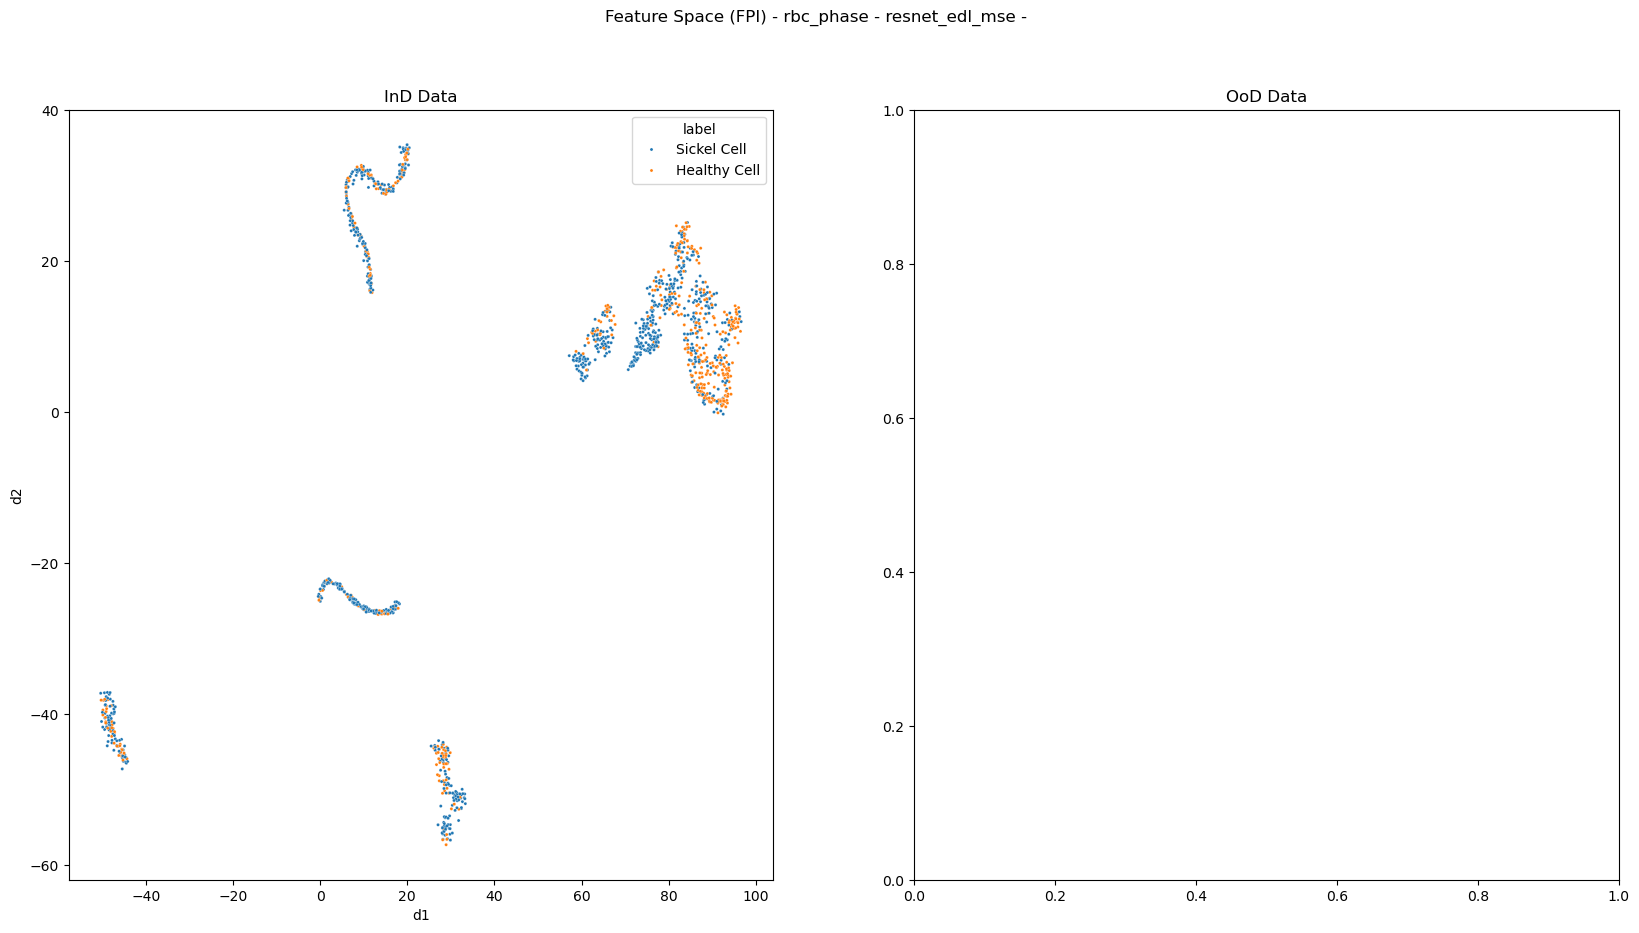

In [12]:
# plot feature space
df_emb_fpi2d = pd.DataFrame()
d1, d2 = ind_emb_fpi2d.T
df_emb_fpi2d = pd.concat([df_emb_fpi2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_emb_fpi2d.T
    df_emb_fpi2d = pd.concat([df_emb_fpi2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Feature Space (FPI) - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_emb_fpi2d[(df_emb_fpi2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_emb_fpi2d[(df_emb_fpi2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

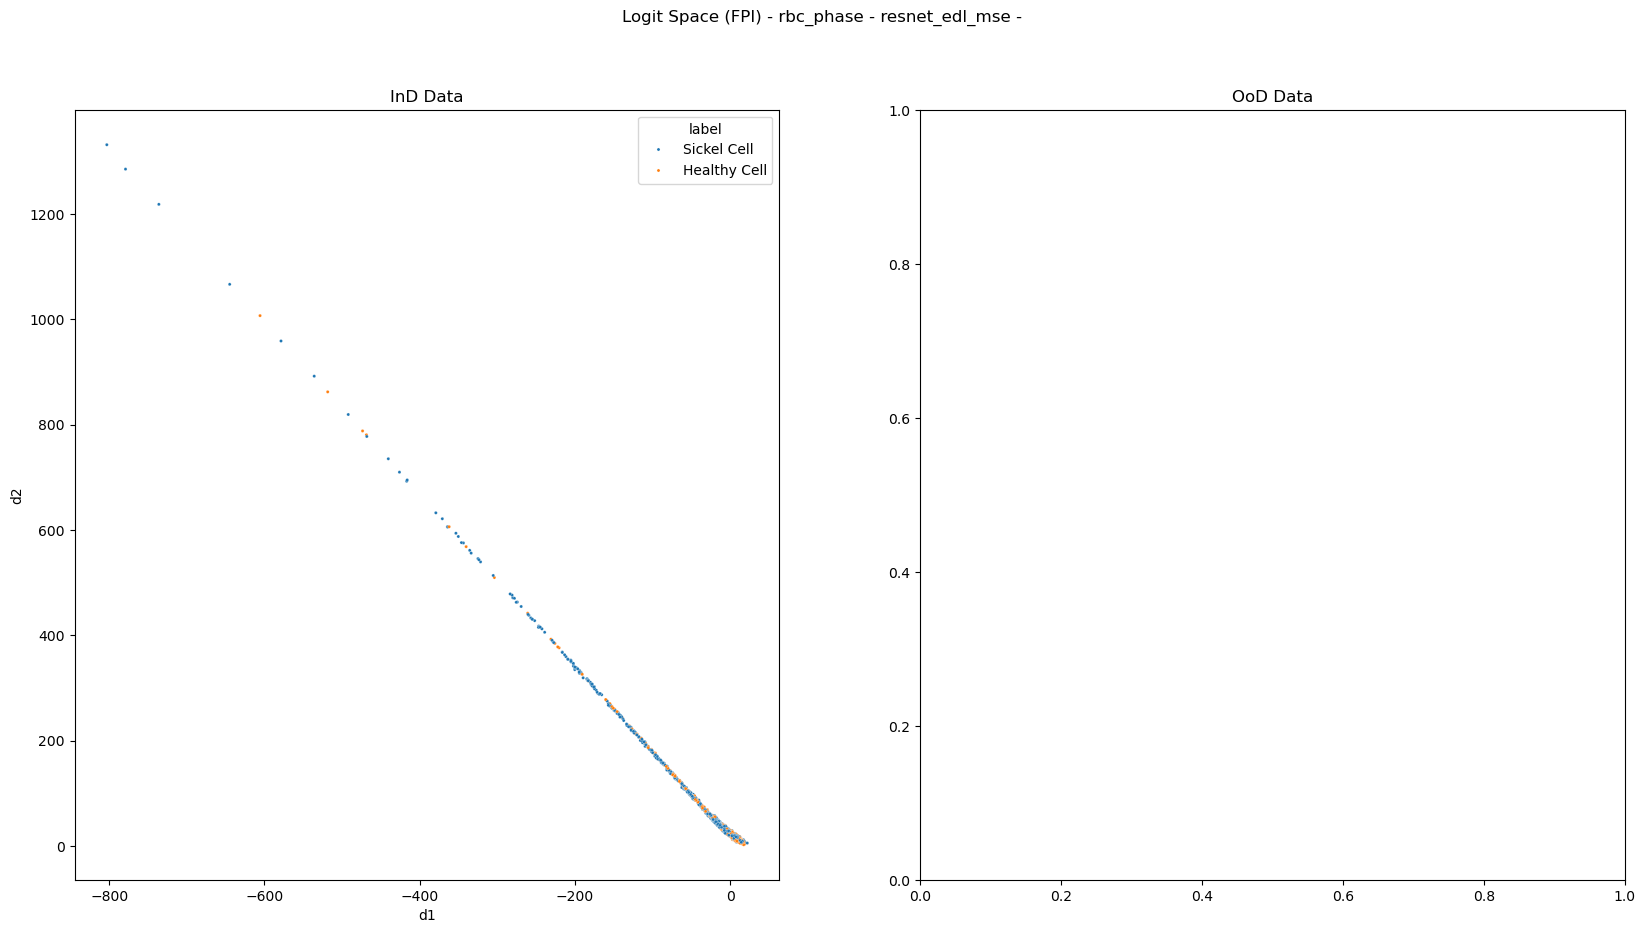

In [13]:
# plot logit space
df_lgt_fpi2d = pd.DataFrame()
d1, d2 = ind_lgt_fpi2d.T
df_lgt_fpi2d = pd.concat([df_lgt_fpi2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_lgt_fpi2d.T
    df_lgt_fpi2d = pd.concat([df_lgt_fpi2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Logit Space (FPI) - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_lgt_fpi2d[(df_lgt_fpi2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_lgt_fpi2d[(df_lgt_fpi2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

  0%|                                                                                                                   | 0/4 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████████████████▌                                                     | 2/4 [00:00<00:00,  6.17it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.62it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.13it/s]

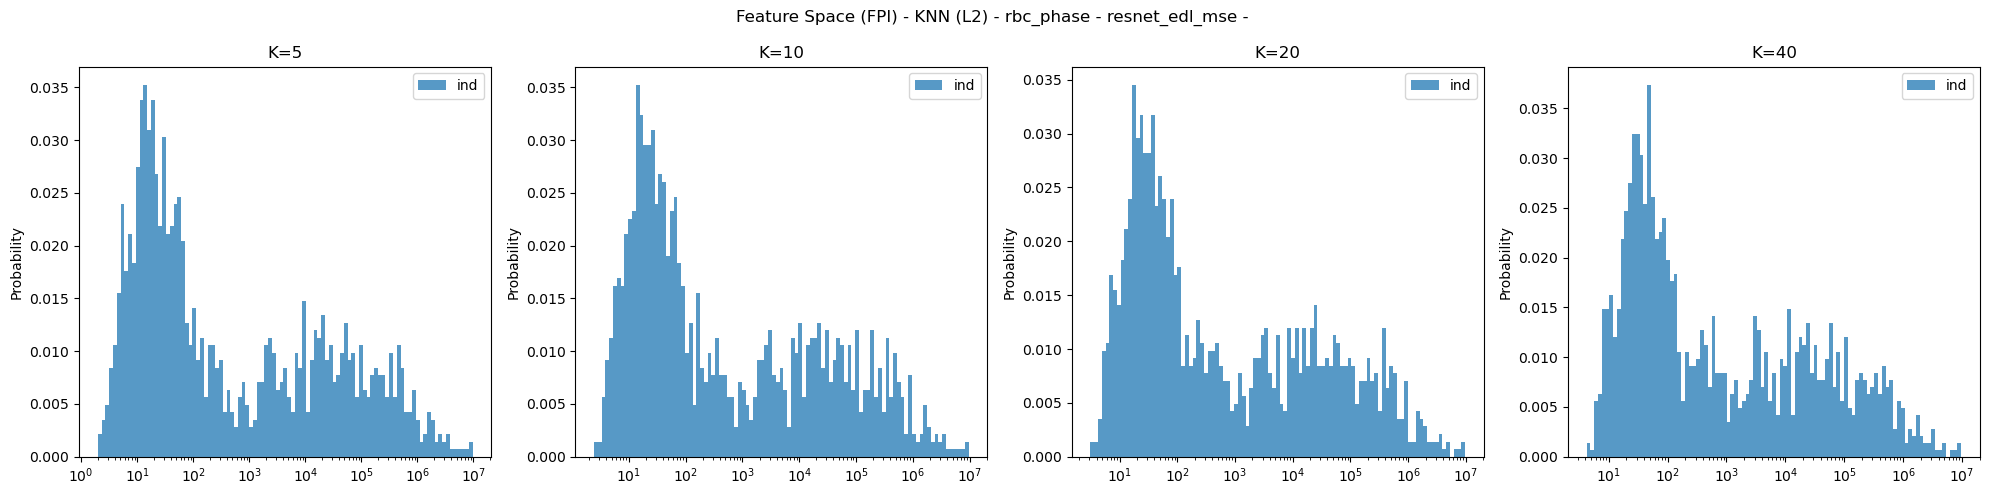

In [14]:
# plot knn to val data in feature space (L2)
index = faiss.IndexFlatL2(ind_emb_fpi.shape[-1])
index.add(val_emb)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Feature Space (FPI) - KNN (L2) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_emb_fpi, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_emb_fpi, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                                                   | 0/4 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████████████████▌                                                     | 2/4 [00:00<00:00, 12.92it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 12.50it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 12.54it/s]

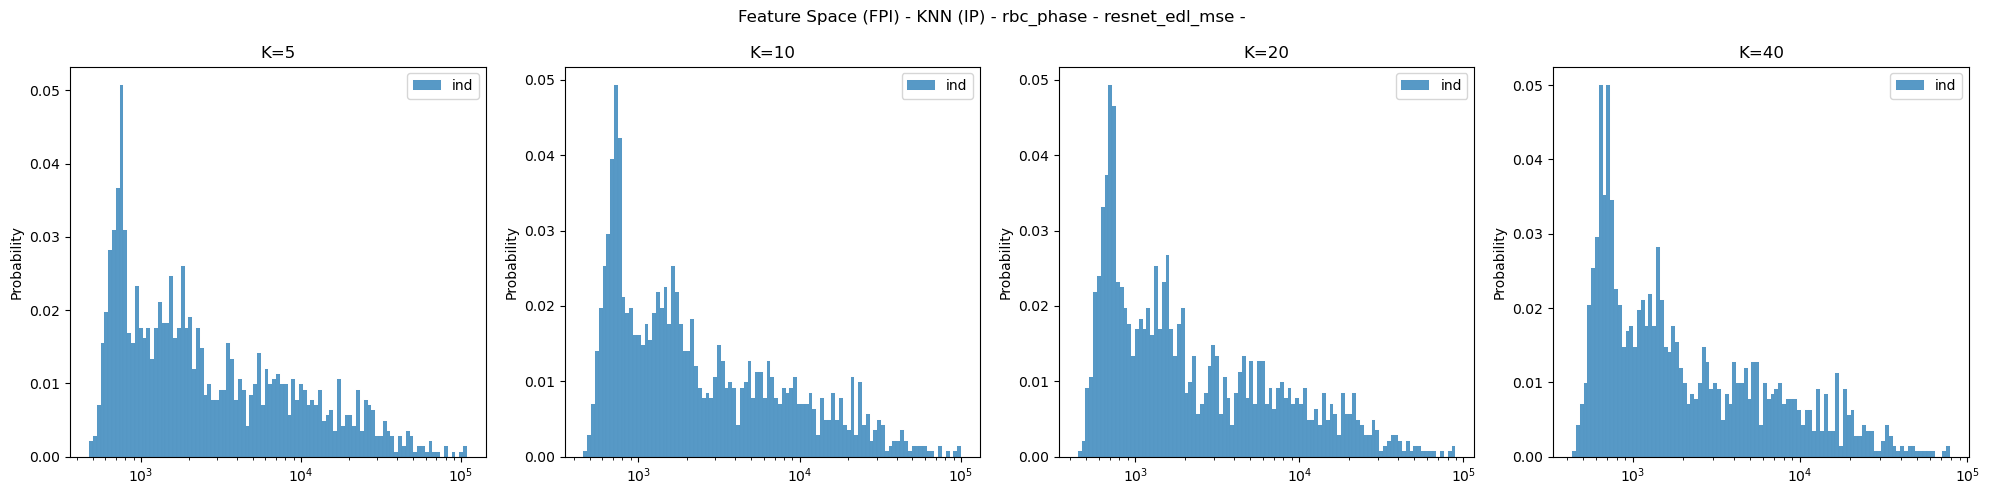

In [15]:
# check knn to val data in feature space (IP)
index = faiss.IndexFlatIP(ind_emb_fpi.shape[-1])
index.add(val_emb)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Feature Space (FPI) - KNN (IP) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_emb_fpi, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_emb_fpi, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                                                   | 0/4 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████████████████▌                                                     | 2/4 [00:00<00:00, 12.47it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 11.89it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 11.96it/s]

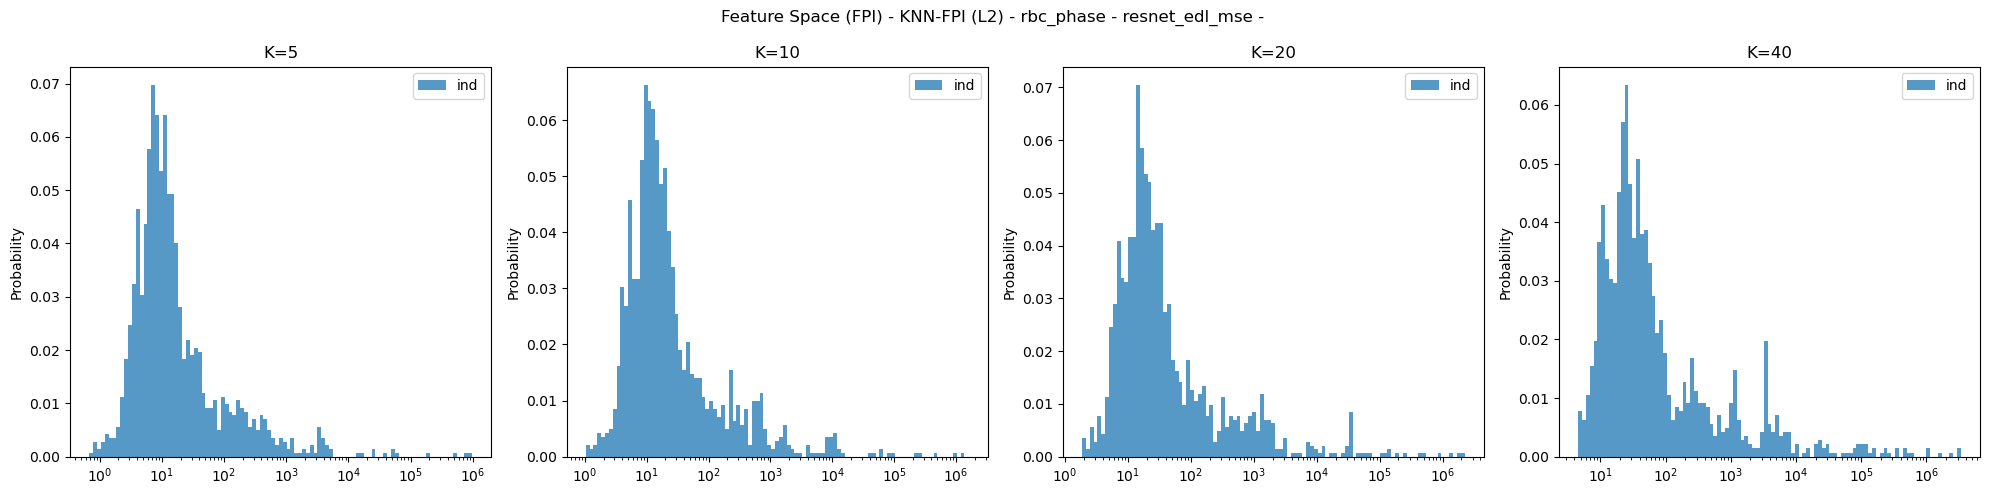

In [16]:
# check knn to val data FPI in feature space (L2)
index = faiss.IndexFlatL2(ind_emb_fpi.shape[-1])
index.add(val_emb_fpi)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Feature Space (FPI) - KNN-FPI (L2) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_emb_fpi, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_emb_fpi, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                                                   | 0/4 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████████████████▌                                                     | 2/4 [00:00<00:00, 12.58it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 12.45it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 12.45it/s]

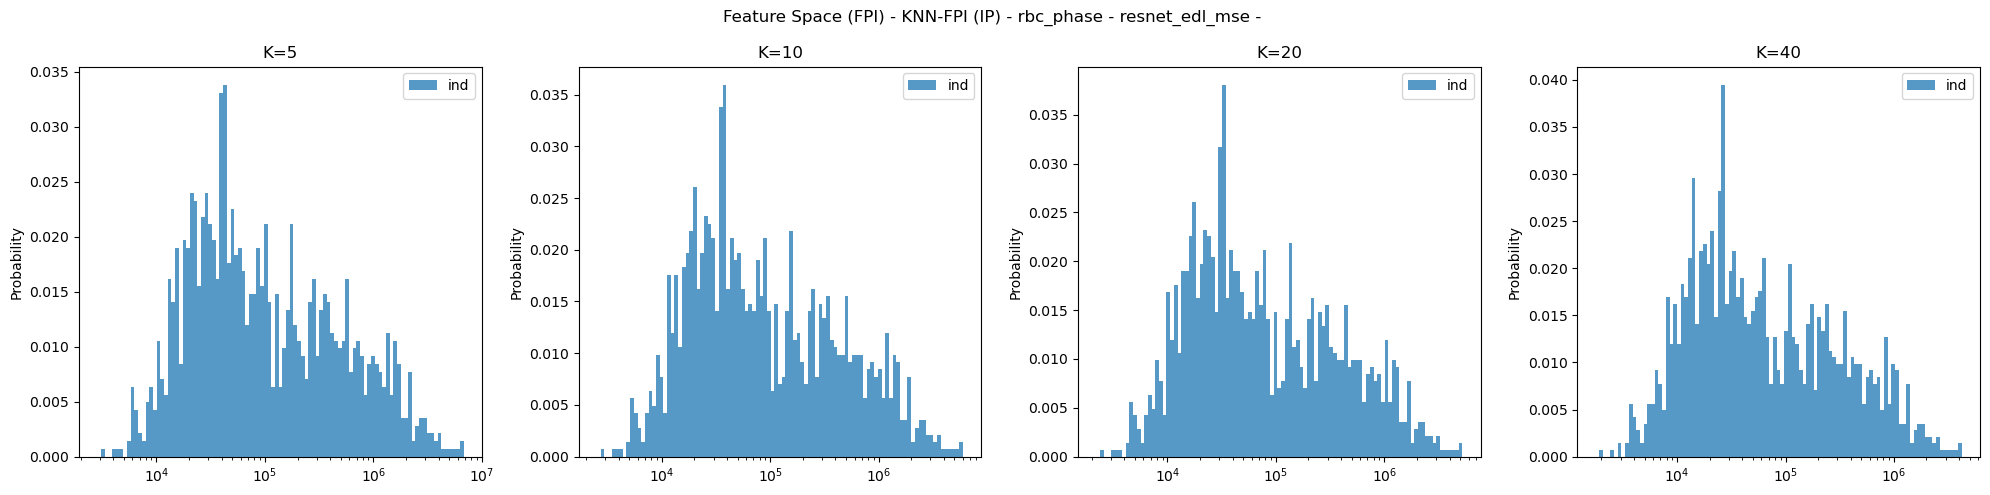

In [17]:
# check knn to val data FPI in feature space (IP)
index = faiss.IndexFlatIP(ind_emb_fpi.shape[-1])
index.add(val_emb_fpi)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Feature Space (FPI) - KNN-FPI (IP) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_emb_fpi, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_emb_fpi, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                                                   | 0/4 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████████████████▌                                                     | 2/4 [00:00<00:00, 15.45it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 15.16it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 15.17it/s]

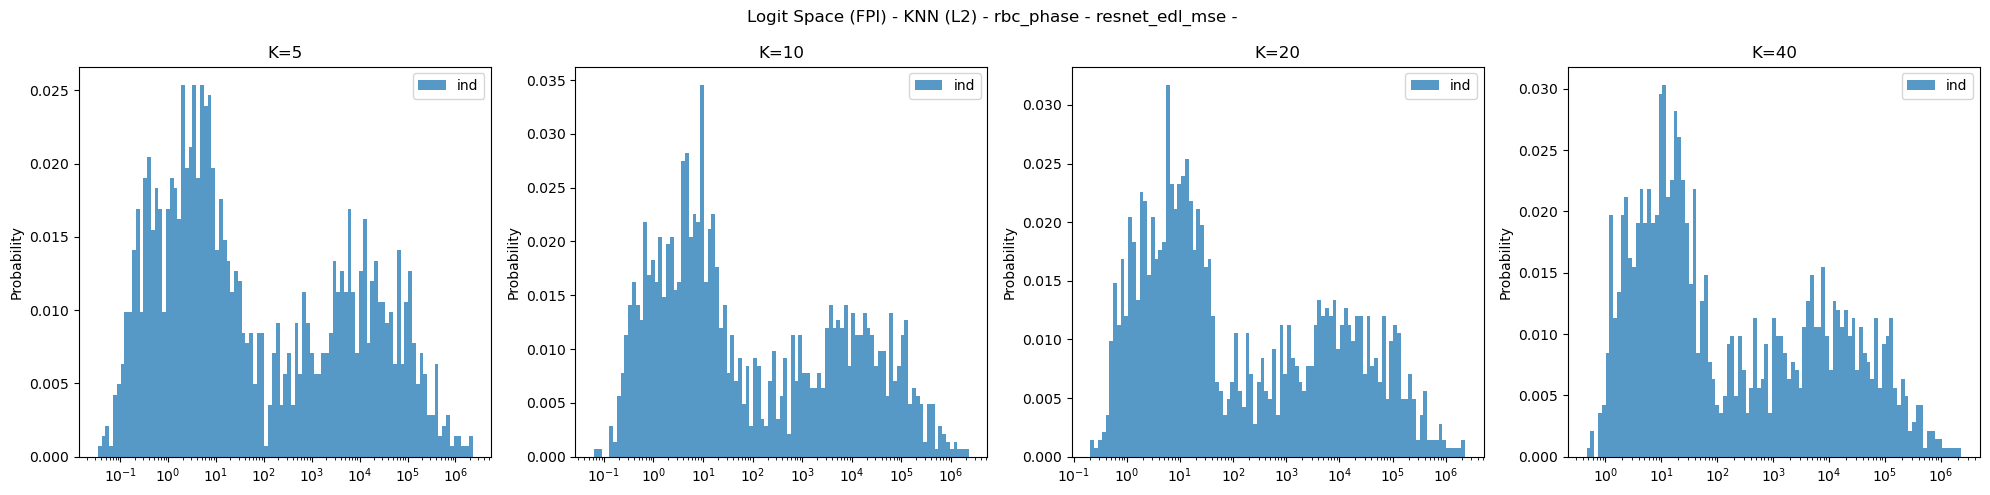

In [18]:
# check knn to val data in logit space (L2)
index = faiss.IndexFlatL2(ind_lgt_fpi.shape[-1])
index.add(val_lgt)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Logit Space (FPI) - KNN (L2) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_lgt_fpi, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_lgt_fpi, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                                                   | 0/4 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████████████████▌                                                     | 2/4 [00:00<00:00, 15.31it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 14.97it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 14.99it/s]

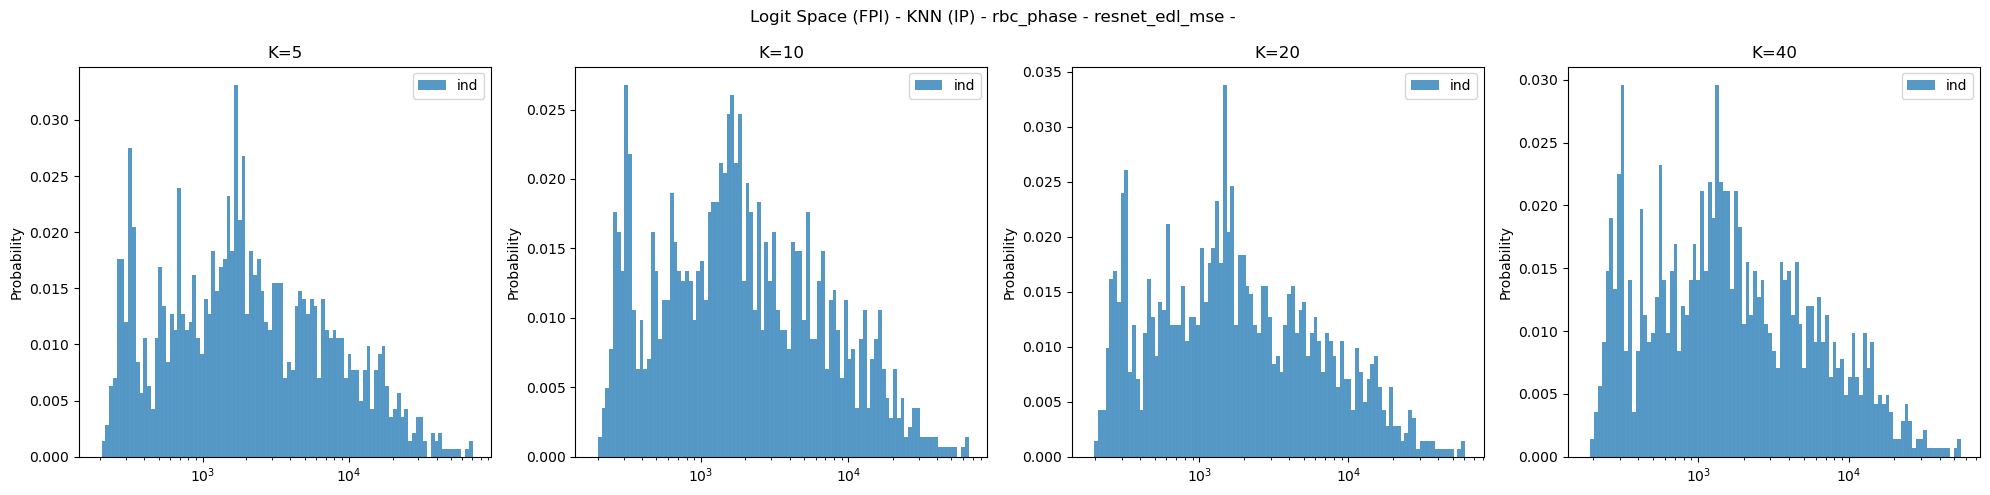

In [19]:
# check knn to val data in logit space (IP)
index = faiss.IndexFlatIP(ind_lgt_fpi.shape[-1])
index.add(val_lgt)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Logit Space (FPI) - KNN (IP) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_lgt_fpi, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_lgt_fpi, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                                                   | 0/4 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████████████████▌                                                     | 2/4 [00:00<00:00, 15.21it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 14.64it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 14.70it/s]

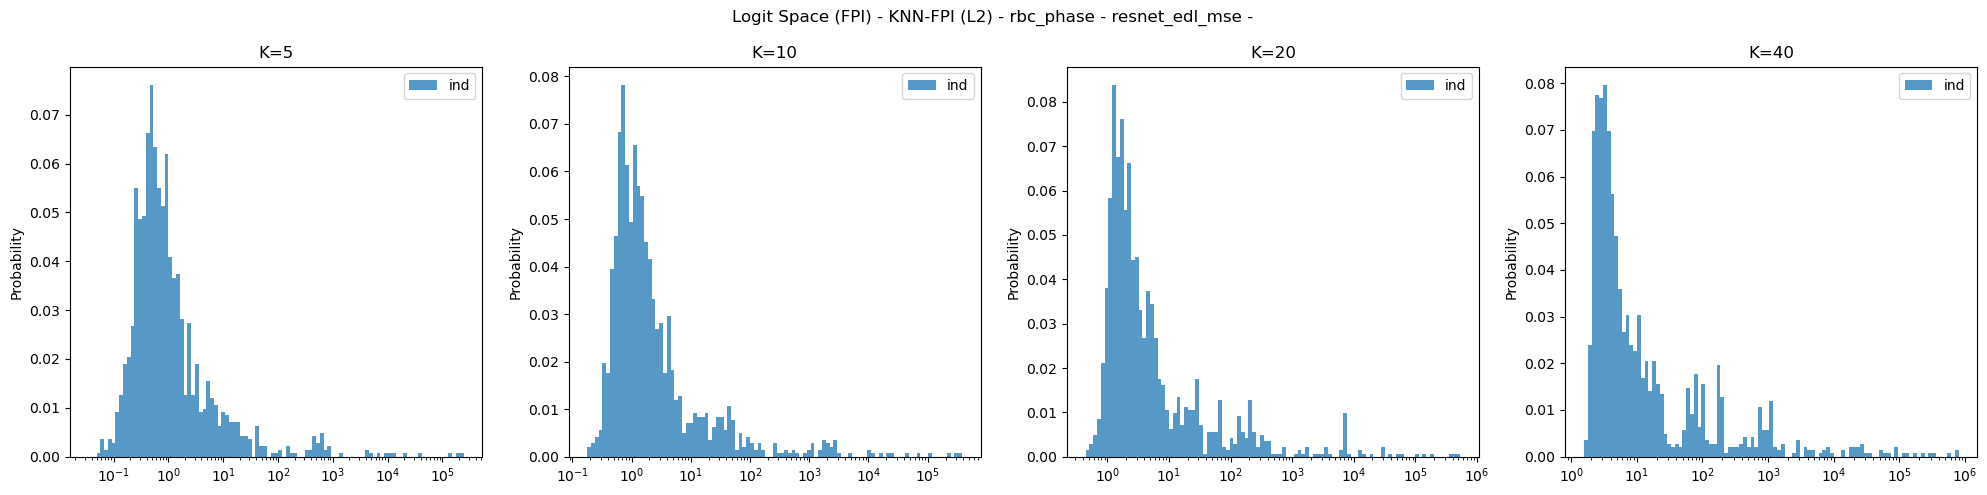

In [20]:
# check knn to val data FPI in logit space (L2)
index = faiss.IndexFlatL2(ind_lgt_fpi.shape[-1])
index.add(val_lgt_fpi)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Logit Space (FPI) - KNN-FPI (L2) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_lgt_fpi, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_lgt_fpi, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                                                   | 0/4 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████████████████▌                                                     | 2/4 [00:00<00:00, 15.22it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 15.22it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 15.19it/s]

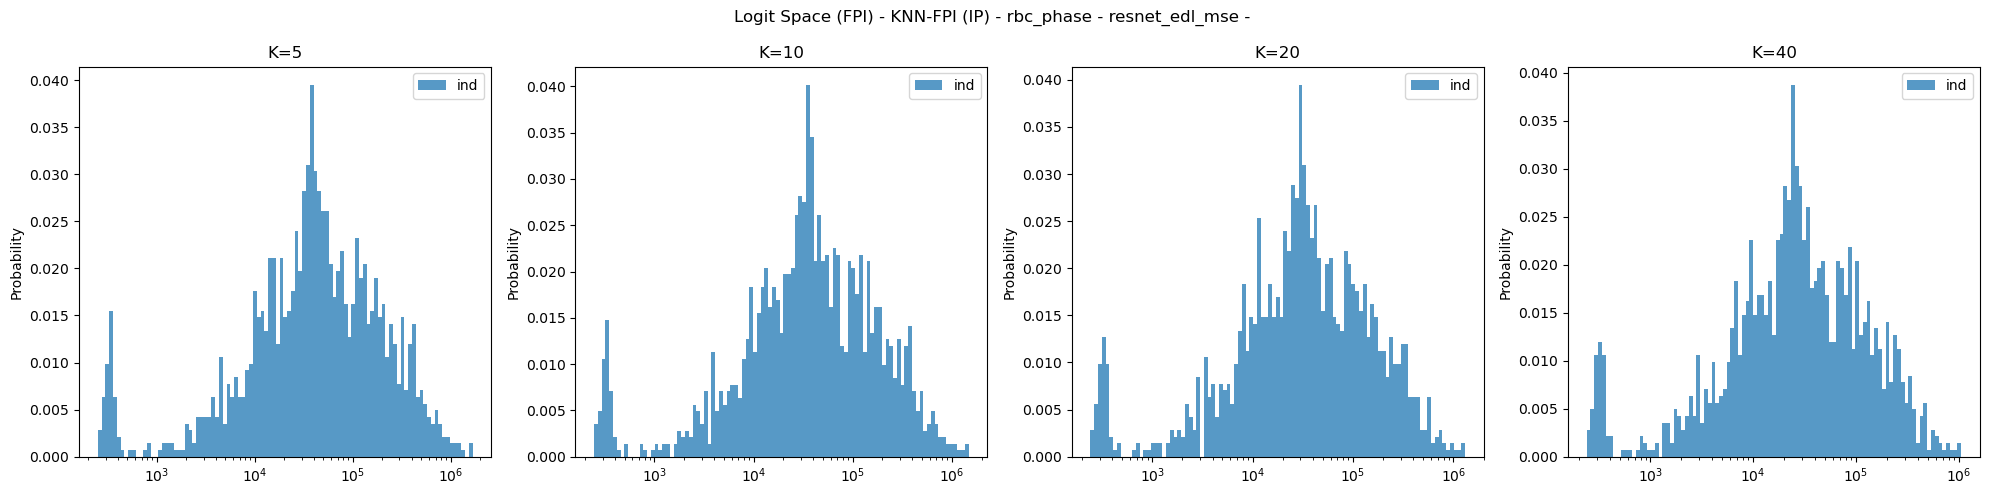

In [21]:
# check knn to val data FPI in logit space (IP)
index = faiss.IndexFlatIP(ind_lgt_fpi.shape[-1])
index.add(val_lgt_fpi)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Logit Space (FPI) - KNN-FPI (IP) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_lgt_fpi, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_lgt_fpi, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

/tmp/ipykernel_2624162/3529225870.py:2: RuntimeWarning: overflow encountered in exp
  ind_prob_fpi = np.exp(ind_lgt_fpi.astype(np.float64)) / np.exp(ind_lgt_fpi.astype(np.float64)).sum(-1, keepdims=True)
/tmp/ipykernel_2624162/3529225870.py:2: RuntimeWarning: invalid value encountered in divide
  ind_prob_fpi = np.exp(ind_lgt_fpi.astype(np.float64)) / np.exp(ind_lgt_fpi.astype(np.float64)).sum(-1, keepdims=True)


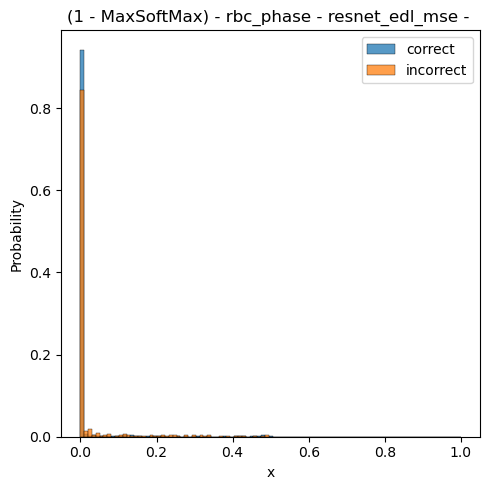

In [22]:
# plot (1 - maxsoftmax) distribution
ind_prob_fpi = np.exp(ind_lgt_fpi.astype(np.float64)) / np.exp(ind_lgt_fpi.astype(np.float64)).sum(-1, keepdims=True)
ind_pred_fpi = ind_prob_fpi.argmax(-1)
ind_ucty_fpi = -ind_prob_fpi.max(-1) + 1.0

if ood_str:
    ood_prob_fpi = np.exp(ood_lgt_fpi.astype(np.float64)) / np.exp(ood_lgt_fpi.astype(np.float64)).sum(-1, keepdims=True)
    ood_pred_fpi = ood_prob_fpi.argmax(-1)
    ood_ucty_fpi = -ood_prob_fpi.max(-1) + 1.0

df_t_fpi = pd.DataFrame({"x": ind_ucty_fpi[ind_pred_fpi == ind_tgt]}).copy()
df_f_fpi = pd.DataFrame({"x": ind_ucty_fpi[ind_pred_fpi != ind_tgt]}).copy()
df_fpi = pd.concat([df_t_fpi, df_f_fpi], ignore_index=True)
if ood_str:
    df_o_fpi = pd.DataFrame({"x": ood_ucty_fpi}).copy()
    df_fpi = pd.concat([df_fpi, df_o_fpi], ignore_index=True)
df_fpi_bins = np.linspace(0, 1, 100)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
sns.histplot(df_t_fpi, x="x", label="correct", stat="probability", bins=df_fpi_bins, ax=ax)
sns.histplot(df_f_fpi, x="x", label="incorrect", stat="probability", bins=df_fpi_bins, ax=ax)
if ood_str:
    sns.histplot(df_o_fpi, x="x", label="ood", stat="probability", bins=df_fpi_bins, ax=ax)
plt.legend()
plt.title(f"(1 - MaxSoftMax) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()

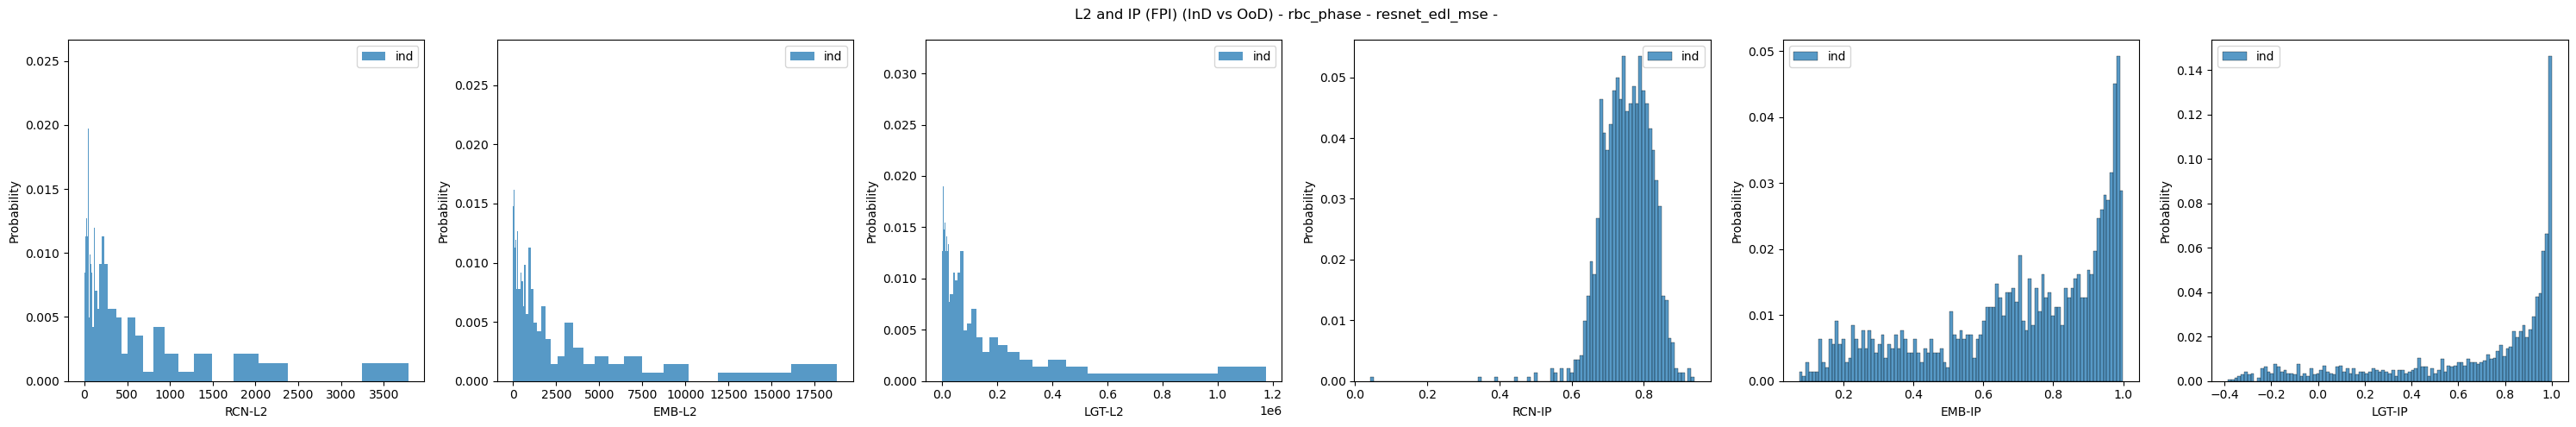

In [23]:
# plot fpi-reconstruction-based ood metrics
fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(nrows=1, ncols=6, figsize=(30, 5))

df_rstat = pd.DataFrame()
ni = ind_inp.shape[0]
si = (ni, -1)
# data
_ind_inp = ind_inp.reshape(si)
_ind_rcn = ind_rcn.reshape(si)
_ind_emb = ind_emb.reshape(si)
_ind_lgt = ind_lgt.reshape(si)
_ind_rcn_fpi = ind_rcn_fpi.reshape(si)
_ind_emb_fpi = ind_emb_fpi.reshape(si)
_ind_lgt_fpi = ind_lgt_fpi.reshape(si)
# unit vectors
_ind_inp_unit = _ind_inp / (np.linalg.norm(_ind_inp, axis=-1, keepdims=True) + 1e-7)
_ind_rcn_unit = _ind_rcn / (np.linalg.norm(_ind_rcn, axis=-1, keepdims=True) + 1e-7)
_ind_emb_unit = _ind_emb / (np.linalg.norm(_ind_emb, axis=-1, keepdims=True) + 1e-7)
_ind_lgt_unit = _ind_lgt / (np.linalg.norm(_ind_lgt, axis=-1, keepdims=True) + 1e-7)
_ind_rcn_fpi_unit = _ind_rcn_fpi / (np.linalg.norm(_ind_rcn_fpi, axis=-1, keepdims=True) + 1e-7)
_ind_emb_fpi_unit = _ind_emb_fpi / (np.linalg.norm(_ind_emb_fpi, axis=-1, keepdims=True) + 1e-7)
_ind_lgt_fpi_unit = _ind_lgt_fpi / (np.linalg.norm(_ind_lgt_fpi, axis=-1, keepdims=True) + 1e-7)
# mse
ind_rcn_l2_fpi = ((_ind_inp - _ind_rcn_fpi) ** 2).mean(-1)
ind_emb_l2_fpi = ((_ind_emb - _ind_emb_fpi) ** 2).mean(-1)
ind_lgt_l2_fpi = ((_ind_lgt - _ind_lgt_fpi) ** 2).mean(-1)
# ip
ind_rcn_ip_fpi = (_ind_inp_unit * _ind_rcn_fpi_unit).sum(-1)
ind_emb_ip_fpi = (_ind_emb_unit * _ind_emb_fpi_unit).sum(-1)
ind_lgt_ip_fpi = (_ind_lgt_unit * _ind_lgt_fpi_unit).sum(-1)
# store
_df = pd.DataFrame(dict(
    target=ind_tgt,
    rcn_l2=ind_rcn_l2_fpi,
    emb_l2=ind_emb_l2_fpi,
    lgt_l2=ind_lgt_l2_fpi,
    rcn_ip=ind_rcn_ip_fpi,
    emb_ip=ind_emb_ip_fpi,
    lgt_ip=ind_lgt_ip_fpi,
    source="ind",
))
df_rstat = pd.concat([df_rstat, _df], ignore_index=True)

if ood_str:
    no = ood_inp.shape[0]
    so = (no, -1)
    # data
    _ood_inp = ood_inp.reshape(so)
    _ood_rcn = ood_rcn.reshape(so)
    _ood_emb = ood_emb.reshape(so)
    _ood_lgt = ood_lgt.reshape(so)
    _ood_rcn_fpi = ood_rcn_fpi.reshape(so)
    _ood_emb_fpi = ood_emb_fpi.reshape(so)
    _ood_lgt_fpi = ood_lgt_fpi.reshape(so)
    # unit vectors
    _ood_inp_unit = _ood_inp / (np.linalg.norm(_ood_inp, axis=-1, keepdims=True) + 1e-7)
    _ood_rcn_unit = _ood_rcn / (np.linalg.norm(_ood_rcn, axis=-1, keepdims=True) + 1e-7)
    _ood_emb_unit = _ood_emb / (np.linalg.norm(_ood_emb, axis=-1, keepdims=True) + 1e-7)
    _ood_lgt_unit = _ood_lgt / (np.linalg.norm(_ood_lgt, axis=-1, keepdims=True) + 1e-7)
    _ood_rcn_fpi_unit = _ood_rcn_fpi / (np.linalg.norm(_ood_rcn_fpi, axis=-1, keepdims=True) + 1e-7)
    _ood_emb_fpi_unit = _ood_emb_fpi / (np.linalg.norm(_ood_emb_fpi, axis=-1, keepdims=True) + 1e-7)
    _ood_lgt_fpi_unit = _ood_lgt_fpi / (np.linalg.norm(_ood_lgt_fpi, axis=-1, keepdims=True) + 1e-7)
    # mse
    ood_rcn_l2_fpi = ((_ood_inp - _ood_rcn_fpi) ** 2).mean(-1)
    ood_emb_l2_fpi = ((_ood_emb - _ood_emb_fpi) ** 2).mean(-1)
    ood_lgt_l2_fpi = ((_ood_lgt - _ood_lgt_fpi) ** 2).mean(-1)
    # ip
    ood_rcn_ip_fpi = (_ood_inp_unit * _ood_rcn_fpi_unit).sum(-1)
    ood_emb_ip_fpi = (_ood_emb_unit * _ood_emb_fpi_unit).sum(-1)
    ood_lgt_ip_fpi = (_ood_lgt_unit * _ood_lgt_fpi_unit).sum(-1)
    # store
    _df = pd.DataFrame(dict(
        target=ood_tgt,
        rcn_l2=ood_rcn_l2_fpi,
        emb_l2=ood_emb_l2_fpi,
        lgt_l2=ood_lgt_l2_fpi,
        rcn_ip=ood_rcn_ip_fpi,
        emb_ip=ood_emb_ip_fpi,
        lgt_ip=ood_lgt_ip_fpi,
        source="ood",
    ))
    df_rstat = pd.concat([df_rstat, _df], ignore_index=True)
    
bins_rcn_l2 = np.logspace(np.log10(df_rstat['rcn_l2'].min() + 1e-7), np.log10(df_rstat['rcn_l2'].max()), 100)
bins_emb_l2 = np.logspace(np.log10(df_rstat['emb_l2'].min() + 1e-7), np.log10(df_rstat['emb_l2'].max()), 100)
bins_lgt_l2 = np.logspace(np.log10(df_rstat['lgt_l2'].min() + 1e-7), np.log10(df_rstat['lgt_l2'].max()), 100)
bins_rcn_ip = np.linspace(df_rstat['rcn_ip'].min(), df_rstat['rcn_ip'].max(), 100)
bins_emb_ip = np.linspace(df_rstat['emb_ip'].min(), df_rstat['emb_ip'].max(), 100)
bins_lgt_ip = np.linspace(df_rstat['lgt_ip'].min(), df_rstat['lgt_ip'].max(), 100)
sns.histplot(df_rstat[df_rstat['source'] == 'ind'], x="rcn_l2", label="ind", stat="probability", bins=bins_rcn_l2, ax=ax1)
sns.histplot(df_rstat[df_rstat['source'] == 'ind'], x="emb_l2", label="ind", stat="probability", bins=bins_emb_l2, ax=ax2)
sns.histplot(df_rstat[df_rstat['source'] == 'ind'], x="lgt_l2", label="ind", stat="probability", bins=bins_lgt_l2, ax=ax3)
sns.histplot(df_rstat[df_rstat['source'] == 'ind'], x="rcn_ip", label="ind", stat="probability", bins=bins_rcn_ip, ax=ax4)
sns.histplot(df_rstat[df_rstat['source'] == 'ind'], x="emb_ip", label="ind", stat="probability", bins=bins_emb_ip, ax=ax5)
sns.histplot(df_rstat[df_rstat['source'] == 'ind'], x="lgt_ip", label="ind", stat="probability", bins=bins_lgt_ip, ax=ax6)

if ood_str:
    sns.histplot(df_rstat[df_rstat['source'] == 'ood'], x="rcn_l2", label="ind", stat="probability", bins=bins_rcn_l2, ax=ax1)
    sns.histplot(df_rstat[df_rstat['source'] == 'ood'], x="emb_l2", label="ind", stat="probability", bins=bins_emb_l2, ax=ax2)
    sns.histplot(df_rstat[df_rstat['source'] == 'ood'], x="lgt_l2", label="ind", stat="probability", bins=bins_lgt_l2, ax=ax3)
    sns.histplot(df_rstat[df_rstat['source'] == 'ood'], x="rcn_ip", label="ind", stat="probability", bins=bins_rcn_ip, ax=ax4)
    sns.histplot(df_rstat[df_rstat['source'] == 'ood'], x="emb_ip", label="ind", stat="probability", bins=bins_emb_ip, ax=ax5)
    sns.histplot(df_rstat[df_rstat['source'] == 'ood'], x="lgt_ip", label="ind", stat="probability", bins=bins_lgt_ip, ax=ax6)

ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend()
ax5.legend()
ax6.legend()
ax1.set_xlabel("RCN-L2")
ax2.set_xlabel("EMB-L2")
ax3.set_xlabel("LGT-L2")
ax4.set_xlabel("RCN-IP")
ax5.set_xlabel("EMB-IP")
ax6.set_xlabel("LGT-IP")
plt.suptitle(f"L2 and IP (FPI) (InD vs OoD) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()